# Break down per Country

Here I will look at how many times a song is on the toplist for each country and in total.

I will also look at time on the toplist.

## Import stuff

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

plt.style.use('seaborn-bright')

%matplotlib inline

In [2]:
# https://matplotlib.org/gallery/style_sheets/style_sheets_reference.html

In [3]:
plt.style.available

['seaborn-dark',
 'seaborn-darkgrid',
 'seaborn-ticks',
 'fivethirtyeight',
 'seaborn-whitegrid',
 'classic',
 '_classic_test',
 'fast',
 'seaborn-talk',
 'seaborn-dark-palette',
 'seaborn-bright',
 'seaborn-pastel',
 'grayscale',
 'seaborn-notebook',
 'ggplot',
 'seaborn-colorblind',
 'seaborn-muted',
 'seaborn',
 'Solarize_Light2',
 'seaborn-paper',
 'bmh',
 'seaborn-white',
 'dark_background',
 'seaborn-poster',
 'seaborn-deep']

## Load data

In [4]:
data = pd.read_csv('./data_top10c_more_lyrics.csv')
data.head(3)

,Unnamed: 0,Position,Streams,Track Name,Artist,ID,Date,Year,Month,Day,Country,Region,Lyrics,Acousticness,Energy,Instrumentalness,Mode,Tempo,Valence
0,0,177,40381,Bye Bye Bye,*NSYNC,4r8lRYnoOGdEi6YyI5OC1o,2017-10-05,2017,10,5,gb,eu,"hey, hey bye bye bye, bye bye bye bye i'm doi...",0.0408,0.928,0.00104,0.0,172.656,0.879
1,1,151,24132,"Merry Christmas, Happy Holidays",*NSYNC,15coTBAzEN1bOeipoNDZAR,2017-12-23,2017,12,23,it,eu,merry christmas and happy holidays merry chris...,0.1030,0.939,0.00000,1.0,105.003,0.756
2,2,78,49766,"Merry Christmas, Happy Holidays",*NSYNC,15coTBAzEN1bOeipoNDZAR,2017-12-24,2017,12,24,it,eu,merry christmas and happy holidays merry chris...,0.1030,0.939,0.00000,1.0,105.003,0.756


## Fix a little bit with the data

#### Get dummies for song per country

In [5]:
country_dum = pd.get_dummies(data['Country'])
country_dum.head(3)

,au,ca,de,fr,gb,it,nl,us
0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,1,0,0
2,0,0,0,0,0,1,0,0


#### Add the country dummies to the big df

In [6]:
data_c = pd.concat([data, country_dum], axis=1)
data_c.head(3)

,Unnamed: 0,Position,Streams,Track Name,Artist,ID,Date,Year,Month,Day,...,Tempo,Valence,au,ca,de,fr,gb,it,nl,us
0,0,177,40381,Bye Bye Bye,*NSYNC,4r8lRYnoOGdEi6YyI5OC1o,2017-10-05,2017,10,5,...,172.656,0.879,0,0,0,0,1,0,0,0
1,1,151,24132,"Merry Christmas, Happy Holidays",*NSYNC,15coTBAzEN1bOeipoNDZAR,2017-12-23,2017,12,23,...,105.003,0.756,0,0,0,0,0,1,0,0
2,2,78,49766,"Merry Christmas, Happy Holidays",*NSYNC,15coTBAzEN1bOeipoNDZAR,2017-12-24,2017,12,24,...,105.003,0.756,0,0,0,0,0,1,0,0


#### Group by song ID, summing up each column

In [7]:
data_c_groupbyID = data_c.groupby('ID').sum()
data_c_groupbyID.head(3)

,Unnamed: 0,Position,Streams,Year,Month,Day,Acousticness,Energy,Instrumentalness,Mode,Tempo,Valence,au,ca,de,fr,gb,it,nl,us
ID,,,,,,,,,,,,,,,,,,,,
000xQL6tZNLJzIrtIgxqSl,485336363,85033,62948380,1716467,4972,13379,111.48100,533.577,0.000000,851.0,102939.513,445.924,228.0,108.0,55.0,20.0,211.0,53.0,108.0,68.0
007d7JT41sSc1HqWTs4uw7,624441,563,233403,6051,8,30,0.00912,2.286,0.000000,0.0,368.748,0.972,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
00BuKLSAFkaEkaVAgIMbeA,310234,121,209865,2017,2,6,0.00587,0.832,0.000789,0.0,122.021,0.713,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


#### Drop columns that I do not need for this

In [8]:
dataID_c = data_c_groupbyID.drop(['Unnamed: 0', 'Position', 'Streams', 'Year', 'Month', 'Day', 'Acousticness',
                        'Energy', 'Instrumentalness', 'Mode', 'Tempo', 'Valence'], axis=1)
dataID_c.head(3)

,au,ca,de,fr,gb,it,nl,us
ID,,,,,,,,
000xQL6tZNLJzIrtIgxqSl,228.0,108.0,55.0,20.0,211.0,53.0,108.0,68.0
007d7JT41sSc1HqWTs4uw7,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
00BuKLSAFkaEkaVAgIMbeA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


We can now see how many times a song appear on the top list for each country.
Reminder, maximum time possible on the top list is 365 days.

We could have done it per country with this code:<BR />
*data_c.groupby('ID')['au'].sum().reset_index()*

**Check that we do not have any missing data**

In [9]:
dataID_c.isnull().sum()

au    0
ca    0
de    0
fr    0
gb    0
it    0
nl    0
us    0
dtype: int64

#### Make a column for total and average times on toplist for each song

In [10]:
a = dataID_c.T.sum().T

In [11]:
b = dataID_c.T.mean().T

In [12]:
dataID_c['total_toplist'] = a

In [13]:
dataID_c['average_toplist'] = b 

In [14]:
dataID_c.head(3)

,au,ca,de,fr,gb,it,nl,us,total_toplist,average_toplist
ID,,,,,,,,,,
000xQL6tZNLJzIrtIgxqSl,228.0,108.0,55.0,20.0,211.0,53.0,108.0,68.0,851.0,106.375
007d7JT41sSc1HqWTs4uw7,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,3.0,0.375
00BuKLSAFkaEkaVAgIMbeA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.125


In [15]:
# Maximum total times on toplist
365*8

2920

#### Make a new column for ID so that I can merge on ID later

In [16]:
dataID_c['ID'] = dataID_c.index
dataID_c.head(3)

,au,ca,de,fr,gb,it,nl,us,total_toplist,average_toplist,ID
ID,,,,,,,,,,,
000xQL6tZNLJzIrtIgxqSl,228.0,108.0,55.0,20.0,211.0,53.0,108.0,68.0,851.0,106.375,000xQL6tZNLJzIrtIgxqSl
007d7JT41sSc1HqWTs4uw7,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,3.0,0.375,007d7JT41sSc1HqWTs4uw7
00BuKLSAFkaEkaVAgIMbeA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.125,00BuKLSAFkaEkaVAgIMbeA


#### Drop rows in the original df data that are duplicates and keep only one row for each song (based on ID)

In [17]:
data_per_song = data.drop_duplicates(subset=['ID'], keep='first')
data_per_song.head(3)

,Unnamed: 0,Position,Streams,Track Name,Artist,ID,Date,Year,Month,Day,Country,Region,Lyrics,Acousticness,Energy,Instrumentalness,Mode,Tempo,Valence
0,0,177,40381,Bye Bye Bye,*NSYNC,4r8lRYnoOGdEi6YyI5OC1o,2017-10-05,2017,10,5,gb,eu,"hey, hey bye bye bye, bye bye bye bye i'm doi...",0.0408,0.928,0.00104,0.0,172.656,0.8790
1,1,151,24132,"Merry Christmas, Happy Holidays",*NSYNC,15coTBAzEN1bOeipoNDZAR,2017-12-23,2017,12,23,it,eu,merry christmas and happy holidays merry chris...,0.1030,0.939,0.00000,1.0,105.003,0.7560
43,43,147,43037,Douce Nuit,-M-,4EOJWkvkVDpkZrhC8iTDsI,2017-12-24,2017,12,24,fr,eu,NaN,0.9140,0.227,0.16300,1.0,81.887,0.0498


#### Drop all columns in the df data that are not Track Name, Artist or ID

In [18]:
data_per_song = data_per_song.drop(['Unnamed: 0', 'Position', 'Streams', 'Date', 'Year', 'Month', 'Day', 'Country',
                                   'Region', 'Lyrics', 'Acousticness', 'Energy', 'Instrumentalness', 'Mode',
                                   'Tempo', 'Valence'], axis=1)
data_per_song.head(3)

,Track Name,Artist,ID
0,Bye Bye Bye,*NSYNC,4r8lRYnoOGdEi6YyI5OC1o
1,"Merry Christmas, Happy Holidays",*NSYNC,15coTBAzEN1bOeipoNDZAR
43,Douce Nuit,-M-,4EOJWkvkVDpkZrhC8iTDsI


### On the top list in how many of the 8 countries?

#### Combine the 2 data frames on ID column

In [19]:
big_df_song = data_per_song.merge(dataID_c, how='inner', on='ID')
big_df_song.head(3)

,Track Name,Artist,ID,au,ca,de,fr,gb,it,nl,us,total_toplist,average_toplist
0,Bye Bye Bye,*NSYNC,4r8lRYnoOGdEi6YyI5OC1o,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.125
1,"Merry Christmas, Happy Holidays",*NSYNC,15coTBAzEN1bOeipoNDZAR,2.0,4.0,24.0,0.0,1.0,3.0,4.0,4.0,42.0,5.250
2,Douce Nuit,-M-,4EOJWkvkVDpkZrhC8iTDsI,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.125


How to interpret the data frame:<BR />
*For example the song Bye Bye Bye by NSYNC only appear on toplists in total 1 time. That is is Great Britain. So on average between the coutries it's on the toplist 0.125 times. We can also say that the song is on the toplist 1/(365x8) of all possible time.*

### What song is appearing the most on a toplist in total?

How long is it up in total and per country?

In [20]:
big_df_song.sort_values(by=['total_toplist'], ascending=False).head(3)

,Track Name,Artist,ID,au,ca,de,fr,gb,it,nl,us,total_toplist,average_toplist
1990,Shape of You,Ed Sheeran,7qiZfU4dY1lWllzX7mPBI3,357.0,357.0,357.0,357.0,357.0,357.0,357.0,357.0,2856.0,357.000
3239,Say You Won't Let Go,James Arthur,5uCax9HTNlzGybIStD3vDh,362.0,360.0,218.0,183.0,360.0,276.0,361.0,361.0,2481.0,310.125
1902,One Dance,Drake,1xznGGDReH1oQq0xzbwXa3,360.0,356.0,267.0,330.0,359.0,237.0,237.0,330.0,2476.0,309.500


In [21]:
2856/(365*8)

0.9780821917808219

How to interpret the output:<BR />
*The song that appear on the toplist the most in total is Shape of You by Ed Sheeran. It is on the toplist 97.8% of all time it can be on a toplist. On average between the 8 countries it is on the toplist for 357 days of the year. In this case the song is as popular in every country.*

### What song is the most popular in what country?

**Australia**

In [22]:
big_df_song.sort_values(by=['au'], ascending=False).head(3)

,Track Name,Artist,ID,au,ca,de,fr,gb,it,nl,us,total_toplist,average_toplist
1292,Redbone,Childish Gambino,3kxfsdsCpFgN412fpnW85Y,362.0,361.0,72.0,83.0,353.0,15.0,78.0,362.0,1686.0,210.750
3239,Say You Won't Let Go,James Arthur,5uCax9HTNlzGybIStD3vDh,362.0,360.0,218.0,183.0,360.0,276.0,361.0,361.0,2481.0,310.125
7395,Mr. Brightside,The Killers,7oK9VyNzrYvRFo7nQEYkWN,362.0,6.0,1.0,0.0,362.0,0.0,0.0,23.0,754.0,94.250


**Canada**

In [23]:
big_df_song.sort_values(by=['ca'], ascending=False).head(3)

,Track Name,Artist,ID,au,ca,de,fr,gb,it,nl,us,total_toplist,average_toplist
7715,goosebumps,Travis Scott,6gBFPUFcJLzWGx4lenP6h2,321.0,362.0,45.0,2.0,234.0,175.0,3.0,362.0,1504.0,188.000
1292,Redbone,Childish Gambino,3kxfsdsCpFgN412fpnW85Y,362.0,361.0,72.0,83.0,353.0,15.0,78.0,362.0,1686.0,210.750
5304,Bad and Boujee (feat. Lil Uzi Vert),Migos,4Km5HrUvYTaSUfiSGPJeQR,278.0,360.0,149.0,169.0,210.0,80.0,122.0,361.0,1729.0,216.125


**Deuchland / Germany**

In [24]:
big_df_song.sort_values(by=['de'], ascending=False).head(3)

,Track Name,Artist,ID,au,ca,de,fr,gb,it,nl,us,total_toplist,average_toplist
880,Ohne mein Team,Bonez MC,05Mp2UJulSttxQ4E6hQPH3,0.0,0.0,362.0,0.0,0.0,0.0,0.0,0.0,362.0,45.25
5087,Solo Dance,Martin Jensen,6HUnnBwYZqcED1eQztxMBN,320.0,243.0,357.0,246.0,336.0,283.0,331.0,128.0,2244.0,280.50
1990,Shape of You,Ed Sheeran,7qiZfU4dY1lWllzX7mPBI3,357.0,357.0,357.0,357.0,357.0,357.0,357.0,357.0,2856.0,357.00


*Comment: The topsong was only poluplar in Germany*

**France**

In [25]:
big_df_song.sort_values(by=['fr'], ascending=False).head(3)

,Track Name,Artist,ID,au,ca,de,fr,gb,it,nl,us,total_toplist,average_toplist
6028,Onizuka,PNL,4GCIYE1x1TWJCChPkpy9by,0.0,0.0,0.0,360.0,0.0,0.0,0.0,0.0,360.0,45.000
6016,Bené,PNL,00X2yv2vrtritPt2CZnUTZ,0.0,0.0,0.0,360.0,0.0,0.0,0.0,0.0,360.0,45.000
5641,Mauvaise graine,Nekfeu,4kKJ5CjwCtksszPMntho4N,0.0,0.0,0.0,357.0,0.0,0.0,0.0,0.0,357.0,44.625


*Comment: The topsong was only poluplar in France*

**Great Britain**

In [26]:
big_df_song.sort_values(by=['gb'], ascending=False).head(3)

,Track Name,Artist,ID,au,ca,de,fr,gb,it,nl,us,total_toplist,average_toplist
7395,Mr. Brightside,The Killers,7oK9VyNzrYvRFo7nQEYkWN,362.0,6.0,1.0,0.0,362.0,0.0,0.0,23.0,754.0,94.250
3239,Say You Won't Let Go,James Arthur,5uCax9HTNlzGybIStD3vDh,362.0,360.0,218.0,183.0,360.0,276.0,361.0,361.0,2481.0,310.125
1902,One Dance,Drake,1xznGGDReH1oQq0xzbwXa3,360.0,356.0,267.0,330.0,359.0,237.0,237.0,330.0,2476.0,309.500


**Italy**

In [27]:
big_df_song.sort_values(by=['it'], ascending=False).head(3)

,Track Name,Artist,ID,au,ca,de,fr,gb,it,nl,us,total_toplist,average_toplist
6887,Visiera A Becco,Sfera Ebbasta,0nB7VgMGBTeOIO6LXwOvEJ,0.0,0.0,0.0,0.0,0.0,362.0,0.0,0.0,362.0,45.25
4923,Veleno 6,Madman,7GfXjqXD9aBvDoBdZ7EwPH,0.0,0.0,0.0,0.0,0.0,362.0,0.0,0.0,362.0,45.25
3095,Chic,Izi,7jUJ2RmT4PFHHq4goMWqm3,0.0,0.0,0.0,0.0,0.0,362.0,0.0,0.0,362.0,45.25


*Comment: The topsong was only poluplar in France*

**The Netherlands**

In [28]:
big_df_song.sort_values(by=['nl'], ascending=False).head(3)

,Track Name,Artist,ID,au,ca,de,fr,gb,it,nl,us,total_toplist,average_toplist
3239,Say You Won't Let Go,James Arthur,5uCax9HTNlzGybIStD3vDh,362.0,360.0,218.0,183.0,360.0,276.0,361.0,361.0,2481.0,310.125
1990,Shape of You,Ed Sheeran,7qiZfU4dY1lWllzX7mPBI3,357.0,357.0,357.0,357.0,357.0,357.0,357.0,357.0,2856.0,357.000
1965,Castle on the Hill,Ed Sheeran,6PCUP3dWmTjcTtXY02oFdT,357.0,310.0,245.0,133.0,357.0,230.0,335.0,233.0,2200.0,275.000


**US**

In [29]:
big_df_song.sort_values(by=['us'], ascending=False).head(3)

,Track Name,Artist,ID,au,ca,de,fr,gb,it,nl,us,total_toplist,average_toplist
7715,goosebumps,Travis Scott,6gBFPUFcJLzWGx4lenP6h2,321.0,362.0,45.0,2.0,234.0,175.0,3.0,362.0,1504.0,188.00
3745,iSpy (feat. Lil Yachty),KYLE,2EEeOnHehOozLq4aS0n6SL,275.0,358.0,124.0,40.0,245.0,90.0,124.0,362.0,1618.0,202.25
1292,Redbone,Childish Gambino,3kxfsdsCpFgN412fpnW85Y,362.0,361.0,72.0,83.0,353.0,15.0,78.0,362.0,1686.0,210.75


### Plot when in topchart for different songs

#### Make Date column into date time

In [30]:
data['Date'].head(3)

0    2017-10-05
1    2017-12-23
2    2017-12-24
Name: Date, dtype: object

In [31]:
data['Date'].dtype

dtype('O')

In [32]:
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')

In [33]:
data['Date'].dtype

dtype('<M8[ns]')

#### Look at each country individually

In [34]:
data['Country'].unique()

array(['gb', 'it', 'us', 'de', 'ca', 'nl', 'au', 'fr'], dtype=object)

In [35]:
# filter by country and make 8 new data frames
gb_data = data[data['Country'] == 'gb']
it_data = data[data['Country'] == 'it']
us_data = data[data['Country'] == 'us']
de_data = data[data['Country'] == 'de']
ca_data = data[data['Country'] == 'ca']
nl_data = data[data['Country'] == 'nl']
au_data = data[data['Country'] == 'au']
fr_data = data[data['Country'] == 'fr']

In [36]:
# Be om hjalp for att gora funktion for det nedan...sa att man kan byta framforallt sang men ocksa land. 

### Second most popular song in all countries James Arthur - Say You Won't Let Go

**James Arthur - Say You Won't Let Go**

In [88]:
# Great Britain
gb_data[data['ID'] == '5uCax9HTNlzGybIStD3vDh']
gb_position = gb_data[data['ID'] == '5uCax9HTNlzGybIStD3vDh']['Position']
gb_date = gb_data[data['ID'] == '5uCax9HTNlzGybIStD3vDh']['Date']
gb_song = pd.concat([gb_position, gb_date], axis=1)
gb_song = gb_song.set_index('Date')

# Italy
it_data[data['ID'] == '5uCax9HTNlzGybIStD3vDh']
it_position = it_data[data['ID'] == '5uCax9HTNlzGybIStD3vDh']['Position']
it_date = it_data[data['ID'] == '5uCax9HTNlzGybIStD3vDh']['Date']
it_song = pd.concat([it_position, it_date], axis=1)
it_song = it_song.set_index('Date')

# US
us_data[data['ID'] == '5uCax9HTNlzGybIStD3vDh']
us_position = us_data[data['ID'] == '5uCax9HTNlzGybIStD3vDh']['Position']
us_date = us_data[data['ID'] == '5uCax9HTNlzGybIStD3vDh']['Date']
us_song = pd.concat([us_position, us_date], axis=1)
us_song = us_song.set_index('Date')

# Deutchland / Germany 
de_data[data['ID'] == '5uCax9HTNlzGybIStD3vDh']
de_position = de_data[data['ID'] == '5uCax9HTNlzGybIStD3vDh']['Position']
de_date = de_data[data['ID'] == '5uCax9HTNlzGybIStD3vDh']['Date']
de_song = pd.concat([de_position, de_date], axis=1)
de_song = de_song.set_index('Date')

# Canada
ca_data[data['ID'] == '5uCax9HTNlzGybIStD3vDh']
ca_position = ca_data[data['ID'] == '5uCax9HTNlzGybIStD3vDh']['Position']
ca_date = ca_data[data['ID'] == '5uCax9HTNlzGybIStD3vDh']['Date']
ca_song = pd.concat([ca_position, ca_date], axis=1)
ca_song = ca_song.set_index('Date')

# The Netherlands
nl_data[data['ID'] == '5uCax9HTNlzGybIStD3vDh']
nl_position = nl_data[data['ID'] == '5uCax9HTNlzGybIStD3vDh']['Position']
nl_date = nl_data[data['ID'] == '5uCax9HTNlzGybIStD3vDh']['Date']
nl_song = pd.concat([nl_position, nl_date], axis=1)
nl_song = nl_song.set_index('Date')

# Australia
au_data[data['ID'] == '5uCax9HTNlzGybIStD3vDh']
au_position = au_data[data['ID'] == '5uCax9HTNlzGybIStD3vDh']['Position']
au_date = au_data[data['ID'] == '5uCax9HTNlzGybIStD3vDh']['Date']
au_song = pd.concat([au_position, au_date], axis=1)
au_song = au_song.set_index('Date')

# France
fr_data[data['ID'] == '5uCax9HTNlzGybIStD3vDh']
fr_position = fr_data[data['ID'] == '5uCax9HTNlzGybIStD3vDh']['Position']
fr_date = fr_data[data['ID'] == '5uCax9HTNlzGybIStD3vDh']['Date']
fr_song = pd.concat([fr_position, fr_date], axis=1)
fr_song = fr_song.set_index('Date')

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:22: UserWarning: Boolean Series key will be reindexed t

#### Combine in one plot

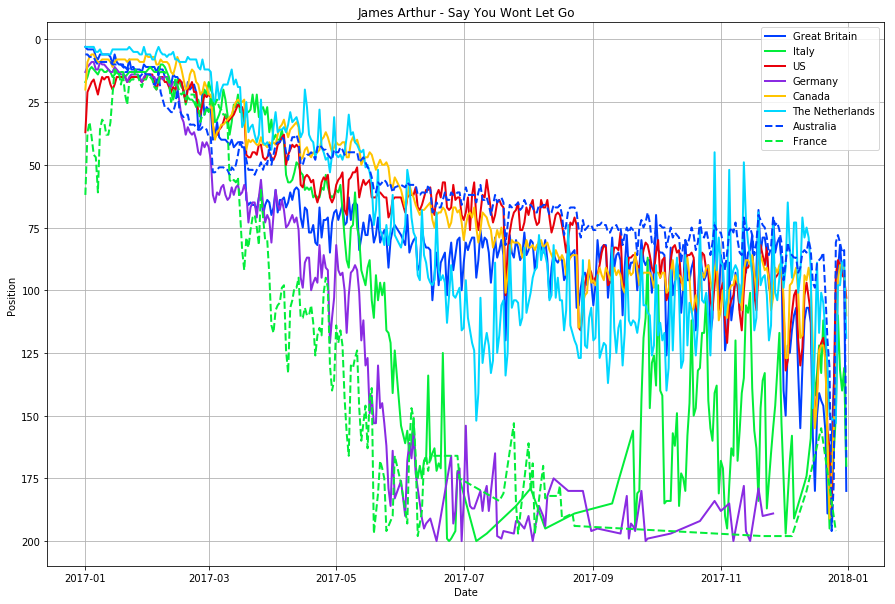

In [89]:
fig, ax = plt.subplots(figsize=(15,10))

ax.plot(gb_song, label='Great Britain', linewidth=2) # use iloc to only the every 7th day -> smoother line
ax.plot(it_song, label='Italy', linewidth=2)
ax.plot(us_song, label='US', linewidth=2)
ax.plot(de_song, label='Germany', linewidth=2)
ax.plot(ca_song, label='Canada', linewidth=2)
ax.plot(nl_song, label='The Netherlands', linewidth=2)
ax.plot(au_song, label='Australia', linestyle='--', linewidth=2)
ax.plot(fr_song, label='France', linestyle='--', linewidth=2)

plt.gca().invert_yaxis() # invert values on Y-axis

plt.xlabel('Date');
plt.ylabel('Position');
plt.title('James Arthur - Say You Wont Let Go');
plt.legend();
plt.grid()

**Smoother plot**

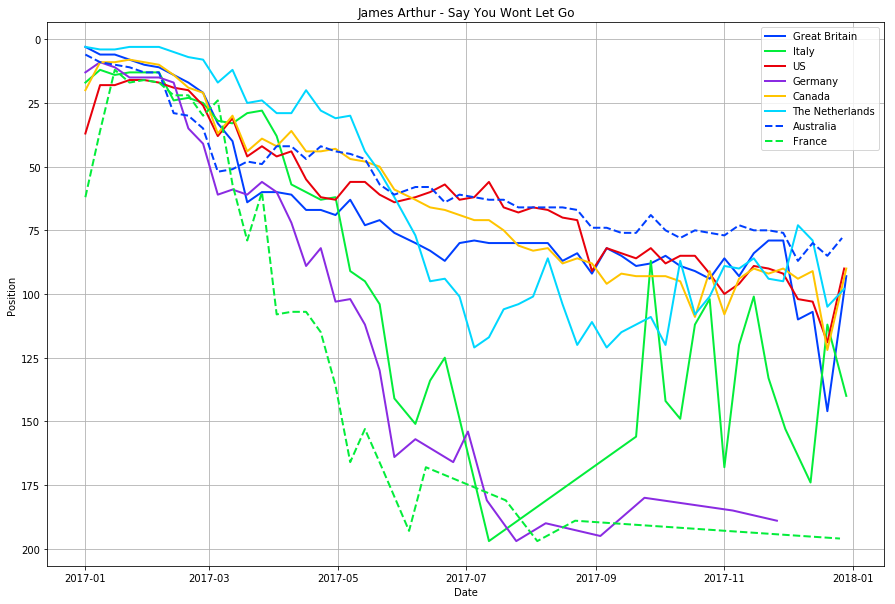

In [87]:
fig, ax = plt.subplots(figsize=(15,10))

ax.plot(gb_song.iloc[::7], label='Great Britain', linewidth=2) # use iloc to only the every 7th day -> smoother line
ax.plot(it_song.iloc[::7], label='Italy', linewidth=2)
ax.plot(us_song.iloc[::7], label='US', linewidth=2)
ax.plot(de_song.iloc[::7], label='Germany', linewidth=2)
ax.plot(ca_song.iloc[::7], label='Canada', linewidth=2)
ax.plot(nl_song.iloc[::7], label='The Netherlands', linewidth=2)
ax.plot(au_song.iloc[::7], label='Australia', linestyle='--', linewidth=2)
ax.plot(fr_song.iloc[::7], label='France', linestyle='--', linewidth=2)

plt.gca().invert_yaxis() # invert values on Y-axis

plt.xlabel('Date');
plt.ylabel('Position');
plt.title('James Arthur - Say You Wont Let Go');
plt.legend();
plt.grid()

### Most popular song in the US Travis Scott - goosebumps

**Travis Scott - goosebumps**

In [91]:
# Great Britain
gb_data[data['ID'] == '6gBFPUFcJLzWGx4lenP6h2']
gb_position = gb_data[data['ID'] == '6gBFPUFcJLzWGx4lenP6h2']['Position']
gb_date = gb_data[data['ID'] == '6gBFPUFcJLzWGx4lenP6h2']['Date']
gb_song = pd.concat([gb_position, gb_date], axis=1)
gb_song2 = gb_song.set_index('Date')

# Italy
it_data[data['ID'] == '6gBFPUFcJLzWGx4lenP6h2']
it_position = it_data[data['ID'] == '6gBFPUFcJLzWGx4lenP6h2']['Position']
it_date = it_data[data['ID'] == '6gBFPUFcJLzWGx4lenP6h2']['Date']
it_song = pd.concat([it_position, it_date], axis=1)
it_song2 = it_song.set_index('Date')

# US
us_data[data['ID'] == '6gBFPUFcJLzWGx4lenP6h2']
us_position = us_data[data['ID'] == '6gBFPUFcJLzWGx4lenP6h2']['Position']
us_date = us_data[data['ID'] == '6gBFPUFcJLzWGx4lenP6h2']['Date']
us_song = pd.concat([us_position, us_date], axis=1)
us_song2 = us_song.set_index('Date')

# Deutchland / Germany 
de_data[data['ID'] == '6gBFPUFcJLzWGx4lenP6h2']
de_position = de_data[data['ID'] == '6gBFPUFcJLzWGx4lenP6h2']['Position']
de_date = de_data[data['ID'] == '6gBFPUFcJLzWGx4lenP6h2']['Date']
de_song = pd.concat([de_position, de_date], axis=1)
de_song2 = de_song.set_index('Date')

# Canada
ca_data[data['ID'] == '6gBFPUFcJLzWGx4lenP6h2']
ca_position = ca_data[data['ID'] == '6gBFPUFcJLzWGx4lenP6h2']['Position']
ca_date = ca_data[data['ID'] == '6gBFPUFcJLzWGx4lenP6h2']['Date']
ca_song = pd.concat([ca_position, ca_date], axis=1)
ca_song2 = ca_song.set_index('Date')

# The Netherlands
nl_data[data['ID'] == '6gBFPUFcJLzWGx4lenP6h2']
nl_position = nl_data[data['ID'] == '6gBFPUFcJLzWGx4lenP6h2']['Position']
nl_date = nl_data[data['ID'] == '6gBFPUFcJLzWGx4lenP6h2']['Date']
nl_song = pd.concat([nl_position, nl_date], axis=1)
nl_song2 = nl_song.set_index('Date')

# Australia
au_data[data['ID'] == '6gBFPUFcJLzWGx4lenP6h2']
au_position = au_data[data['ID'] == '6gBFPUFcJLzWGx4lenP6h2']['Position']
au_date = au_data[data['ID'] == '6gBFPUFcJLzWGx4lenP6h2']['Date']
au_song = pd.concat([au_position, au_date], axis=1)
au_song2 = au_song.set_index('Date')

# France
fr_data[data['ID'] == '6gBFPUFcJLzWGx4lenP6h2']
fr_position = fr_data[data['ID'] == '6gBFPUFcJLzWGx4lenP6h2']['Position']
fr_date = fr_data[data['ID'] == '6gBFPUFcJLzWGx4lenP6h2']['Date']
fr_song = pd.concat([fr_position, fr_date], axis=1)
fr_song2 = fr_song.set_index('Date')

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:16: UserWarning: Boolean Ser

#### Combine in one plot

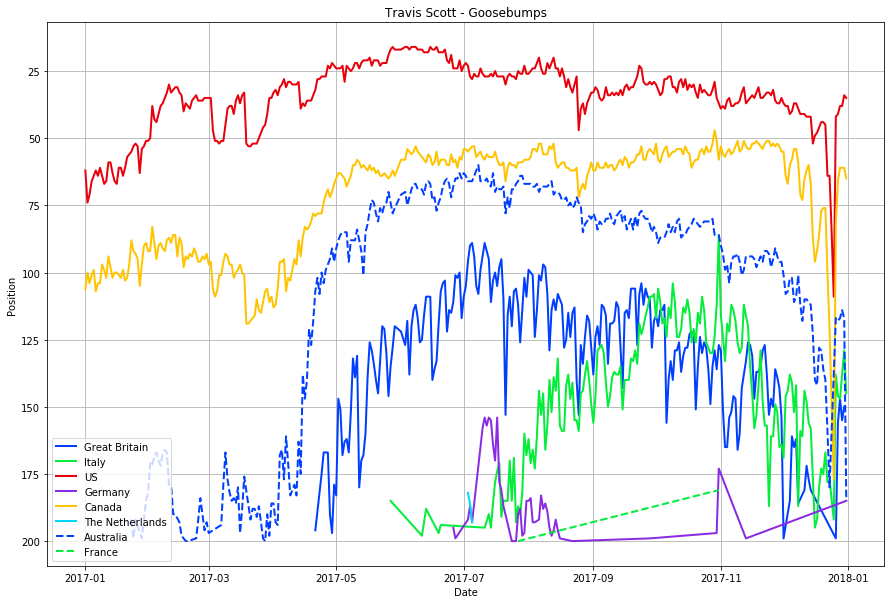

In [94]:
fig, ax = plt.subplots(figsize=(15,10))

ax.plot(gb_song2, label='Great Britain', linewidth=2) # use iloc to only the every 7th day -> smoother line
ax.plot(it_song2, label='Italy', linewidth=2)
ax.plot(us_song2, label='US', linewidth=2)
ax.plot(de_song2, label='Germany', linewidth=2)
ax.plot(ca_song2, label='Canada', linewidth=2)
ax.plot(nl_song2, label='The Netherlands', linewidth=2)
ax.plot(au_song2, label='Australia', linestyle='--', linewidth=2)
ax.plot(fr_song2, label='France', linestyle='--', linewidth=2)

plt.gca().invert_yaxis() # invert values on Y-axis

plt.xlabel('Date');
plt.ylabel('Position');
plt.title('Travis Scott - Goosebumps');
plt.legend();
plt.grid()

**Smoother plot**

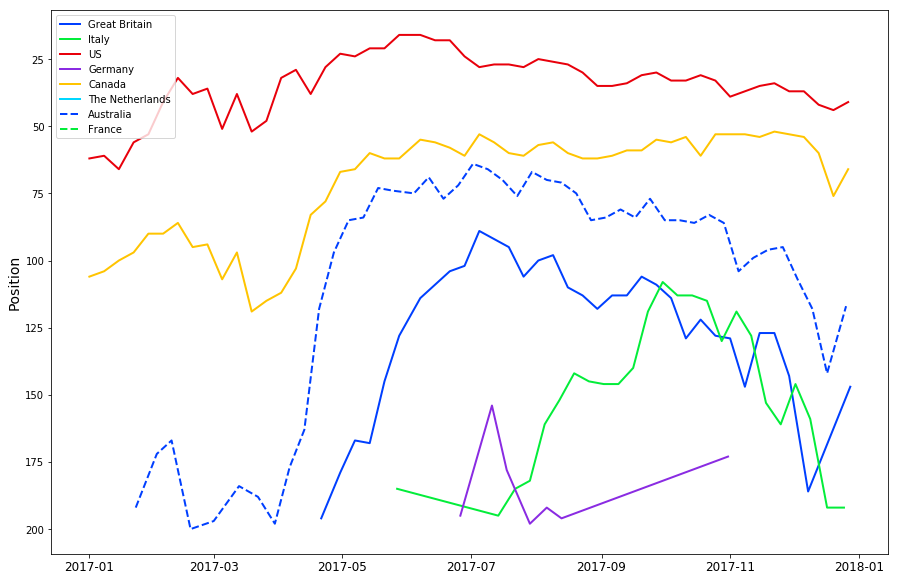

In [105]:
fig, ax = plt.subplots(figsize=(15,10))

ax.plot(gb_song2.iloc[::7], label='Great Britain', linewidth=2) # use iloc to only the every 7th day -> smoother line
ax.plot(it_song2.iloc[::7], label='Italy', linewidth=2)
ax.plot(us_song2.iloc[::7], label='US', linewidth=2)
ax.plot(de_song2.iloc[::7], label='Germany', linewidth=2)
ax.plot(ca_song2.iloc[::7], label='Canada', linewidth=2)
ax.plot(nl_song2.iloc[::7], label='The Netherlands', linewidth=2)
ax.plot(au_song2.iloc[::7], label='Australia', linestyle='--', linewidth=2)
ax.plot(fr_song2.iloc[::7], label='France', linestyle='--', linewidth=2)

plt.gca().invert_yaxis() # invert values on Y-axis

#plt.xlabel('Date');
plt.ylabel('Position');
#plt.title('Most popular song in US 2017: Travis Scott - Goosebumps');

#plt.rc('axes', titlesize=16)     
plt.rc('axes', labelsize=14)    
plt.rc('xtick', labelsize=12)   
plt.rc('xtick', labelsize=12)
plt.rc('figure', titlesize=12)  

plt.legend();
#plt.grid()